# ***SVC***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import os
import pickle  # For saving and loading the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, f1_score, make_scorer
import optuna
from sklearn.ensemble import RandomForestClassifier

import os
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import optuna
import joblib
import time
import numpy as np
pd.options.display.float_format = '{:.3f}'.format

In [2]:
df = pd.read_excel("../Preprocessed data.xlsx")
#df.columns
df.head()

,CAPITAL,CONTEO_PRODUCTOS,Cupo,DiasMejorGestion,DiasUltimaGestion,EDAD,GRUPO,HabitoPago01,HabitoPago03,HabitoPago06,...,CR_Mejor_Gestion_Cliente_No contactado,CR_Mejor_Gestion_Cliente_Sin Gestion,CR_Mejor_Gestion_Cliente_Tercero,NumeroCuotas_2 a 3,NumeroCuotas_3 a 4,NumeroCuotas_4 a 5,NumeroCuotas_5 a 6,NumeroCuotas_6 a 7,Cuenta,Estado
0,0.000,1,0.000,12,0,39,5,0,0,0,...,1,0,0,0,0,0,0,1,300001147679,2
1,474948.570,2,500000.000,18,0,52,5,0,0,0,...,0,0,0,0,0,0,0,0,300001093262,2
2,7000.000,1,2300000.000,18,15,61,5,0,0,1,...,1,0,0,0,1,0,0,0,8151213902,0
3,77946.550,1,400000.000,9,0,64,5,0,0,0,...,1,0,0,0,1,0,0,0,300001722689,2
4,0.000,2,2238800.000,28,1,54,3,0,2,5,...,0,0,0,0,1,0,0,0,202129625174,2


In [3]:
#numeric_cols = ["CAPITAL", "CONTEO_PRODUCTOS", "Cupo", "DiasMejorGestion", "DiasUltimaGestion", "EDAD", 'GRUPO', 'Mora_maxima_cliente__Asignacion', 'PgMin', 'SaldoCliente', 'SaldoVencido', 'TotalGestiones', 'TotalGestionesCD', 'TotalGestionesCI', 'TotalGestionesCompromiso', 'TotalGestionesMasivas', 'TotalGestionesNC', 'dias_mora_Asignacion', 'saldo_total', ]

Study found. Loading from ../Study/optuna_study_SVC.pkl...
Model found. Loading from ../Models/svc_model.pkl...

Validation Metrics:
F1-Score (Validation): 0.8468
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      3211
           1       0.76      0.64      0.70       970
           2       0.78      0.63      0.70       586

    accuracy                           0.85      4767
   macro avg       0.81      0.74      0.77      4767
weighted avg       0.85      0.85      0.85      4767



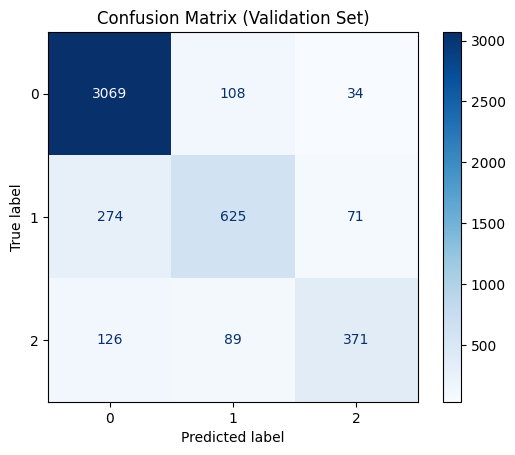

In [4]:
import os
import joblib
import pandas as pd
import numpy as np
import optuna
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Definir columnas numéricas a estandarizar
numeric_cols = ["CAPITAL", "CONTEO_PRODUCTOS", "Cupo", "DiasMejorGestion", "DiasUltimaGestion", "EDAD", 'GRUPO', 'Mora_maxima_cliente__Asignacion', 'PgMin', 'SaldoCliente', 'SaldoVencido', 'TotalGestiones', 'TotalGestionesCD', 'TotalGestionesCI', 'TotalGestionesCompromiso', 'TotalGestionesMasivas', 'TotalGestionesNC', 'dias_mora_Asignacion', 'saldo_total', ]

# Separar características y variable objetivo
X = df.drop(columns=["Cuenta", "Estado"])  # Excluir identificador y objetivo
y = df["Estado"]

# Dividir en conjunto de entrenamiento, validación y prueba (estratificado)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Aplicar StandardScaler solo a las columnas numéricas
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Guardar el scaler para futuras predicciones
scaler_filename = "../Models/scaler.pkl"
joblib.dump(scaler, scaler_filename)

# Definir nombres de archivos para guardar el modelo y el estudio de Optuna
model_filename = "../Models/svc_model.pkl"
study_filename = "../Study/optuna_study_SVC.pkl"

# Función objetivo para Optuna
def objective(trial):
    param = {
        "C": trial.suggest_loguniform("C", 1e-3, 1e3),
        "kernel": trial.suggest_categorical("kernel", ["linear", "rbf", "poly", "sigmoid"]),
        "gamma": trial.suggest_categorical("gamma", ["scale", "auto"]),
    }

    model = SVC(**param, probability=True, random_state=42)
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_val_pred, average="weighted")

    return f1

# Intentar cargar el estudio de Optuna si existe
if os.path.exists(study_filename):
    print(f"Study found. Loading from {study_filename}...")
    study_svc = joblib.load(study_filename)
else:
    print("Study not found. Creating a new one...")
    pruner = optuna.pruners.MedianPruner()
    study_svc = optuna.create_study(direction="maximize", pruner=pruner)

    # Ejecutar la optimización
    start_time = time.time()
    study_svc.optimize(objective, n_trials=50)
    end_time = time.time()

    # Guardar el estudio de Optuna
    joblib.dump(study_svc, study_filename)
    print(f"Study saved as {study_filename}")

    print("Best trial:")
    trial = study_svc.best_trial
    print("  Value:", trial.value)
    print("  Params:", trial.params)
    print(f"Optimization time: {end_time - start_time:.2f} seconds")

# Obtener los mejores parámetros de la optimización
best_params = study_svc.best_params

# Verificar si el modelo ya existe
if os.path.exists(model_filename):
    print(f"Model found. Loading from {model_filename}...")
    svc_model = joblib.load(model_filename)
else:
    # Entrenar el modelo final con los mejores parámetros
    svc_model = SVC(**best_params, probability=True, random_state=42)
    svc_model.fit(X_train, y_train)

    # Guardar el modelo entrenado
    joblib.dump(svc_model, model_filename)
    print(f"Model saved as {model_filename}")
    
# Evaluación en el conjunto de validación
y_val_pred = svc_model.predict(X_val)

print("\nValidation Metrics:")
print(f"F1-Score (Validation): {f1_score(y_val, y_val_pred, average='weighted'):.4f}")
print(classification_report(y_val, y_val_pred))

# Matriz de confusión en validación
conf_matrix_val = confusion_matrix(y_val, y_val_pred)
disp_val = ConfusionMatrixDisplay(conf_matrix_val, display_labels=svc_model.classes_)
disp_val.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Validation Set)")
plt.show()


In [5]:
from reporte_metricas import guardar_reporte

guardar_reporte(y_val, y_val_pred, "SVC Model", "./Metrics/Train_Metrics.csv", "./Metrics/Train_Metrics.json")

📂 Reporte de SVC Model guardado correctamente.


## ***Test Metrics***

In [6]:
# **Evaluación en el conjunto de prueba**
y_test_pred = svc_model.predict(X_test)

# Calcular F1-score, reporte de clasificación y matriz de confusión para `test`
f1_test = f1_score(y_test, y_test_pred, average="weighted")
print("\nTest Metrics:")
print(f"F1-Score (Test): {f1_test:.4f}")
print(classification_report(y_test, y_test_pred))




Test Metrics:
F1-Score (Test): 0.8581
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      3212
           1       0.78      0.67      0.72       969
           2       0.75      0.63      0.68       586

    accuracy                           0.86      4767
   macro avg       0.81      0.75      0.78      4767
weighted avg       0.86      0.86      0.86      4767



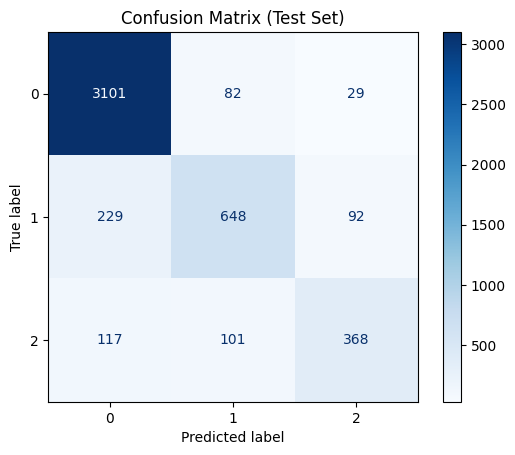

In [7]:
# Matriz de confusión para `test`
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(conf_matrix_test, display_labels=svc_model.classes_)
disp_test.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Test Set)")
plt.show()

## ***Optuna Visualization***

In [8]:
optuna.visualization.plot_optimization_history(study_svc)

In [9]:
optuna.visualization.plot_parallel_coordinate(study_svc)

In [10]:
# Extract F1-scores from each trial in the study
f1_scores = [study_svc.trials[i].value for i in range(len(study_svc.trials))]  # Get the F1-score for each trial

# Create a plotly figure
fig = go.Figure()

# Add a line plot to the figure with the F1-scores
fig.add_trace(go.Scatter(
    x=list(range(len(study_svc.trials))),  # X-axis: Trial number
    y=f1_scores,  # Y-axis: F1-score values
    mode='markers+lines',  # Display both markers and lines
    name='F1-score',  # Label for the line
    line=dict(color='blue'),  # Line color
    marker=dict(color='blue', size=6)  # Marker style
))

# Update layout for the plot
fig.update_layout(
    title="F1-Score Evolution During Optuna Optimization",  # Title of the plot
    xaxis_title="Trial",  # Label for X-axis
    yaxis_title="F1-Score",  # Label for Y-axis
    template="plotly_dark",  # Use dark template for better visibility
    showlegend=False  # Hide legend
)

# Show the plot
fig.show()


In [11]:
optuna.visualization.plot_slice(study_svc, params=['C', 'kernel', 'gamma'])


In [12]:
optuna.visualization.plot_param_importances(study_svc)

In [13]:
svc_model

SVC(C=71.00753181553976, probability=True, random_state=42)

In [14]:
from reporte_metricas import guardar_reporte

guardar_reporte(y_test, y_test_pred, "SVC Model", "./Metrics/Test_Metrics.csv", "./Metrics/Test_Metrics.json")

📂 Reporte de SVC Model guardado correctamente.
